In [125]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from traj_helpers import get_trajectories, normalize_trajectory, resample_trajectory, plot_trajectory
from traj_dataset import TrajDataset
from autoencoders import MLP_VAE
from loss import traj_mse_loss, kl_loss

DRAWING_DIRS = ['jspaint_dataset/00']
LATENT_DIM = 16
POINTS_PER_TRAJ = 32
BETA = 0.0001
NUM_EPOCHS = 2000

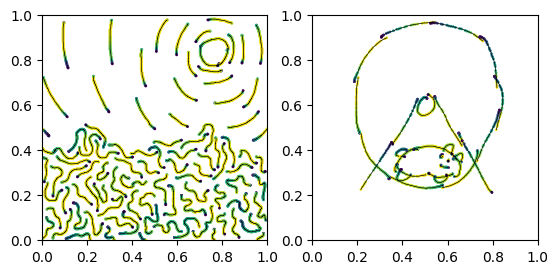

In [126]:
# Plot all the paintings
fig, axs = plt.subplots(1, len(DRAWING_DIRS), squeeze=False)
for (i, dir) in enumerate(DRAWING_DIRS):
    trajectories = get_trajectories([dir])
    for traj in trajectories:
        axs[0][i].set_aspect('equal', 'box')
        axs[0][i].set_xlim(0, 1)
        axs[0][i].set_ylim(0, 1)
        plot_trajectory(axs[0][i], traj)

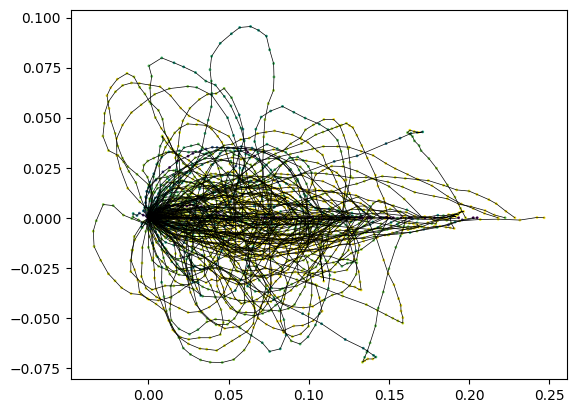

In [124]:
trajectories = get_trajectories(DRAWING_DIRS)
for i in range(len(trajectories)):
    trajectories[i] = normalize_trajectory(trajectories[i])
    trajectories[i] = resample_trajectory(trajectories[i], num_points=POINTS_PER_TRAJ)

fig, ax = plt.subplots()
for trajectory in trajectories:
    plot_trajectory(ax, trajectory)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = TrajDataset(trajectories)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
model = MLP_VAE(
    input_points_per_traj=POINTS_PER_TRAJ,
    latent_dim=LATENT_DIM,
    output_points_per_traj=POINTS_PER_TRAJ
)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(NUM_EPOCHS):
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output, mean, logvar = model(batch)
        mse = traj_mse_loss(batch, output)
        kl = kl_loss(mean, logvar)
        loss = mse + BETA * kl
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(epoch, loss.item())

0 0.021553408354520798
10 0.003434134181588888
20 0.0024415028747171164
30 0.0020560615230351686
40 0.0014365557581186295
50 0.001393534941598773
60 0.0010746789630502462
70 0.0016784020699560642
80 0.001322529511526227
90 0.0013234774814918637
100 0.0011585252359509468
110 0.0011491164332255721
120 0.0009656515903770924
130 0.0012867689365521073
140 0.0008842552197165787
150 0.0011945707956328988
160 0.001012988155707717
170 0.00083078135503456
180 0.0009004150633700192
190 0.0009274049079976976
200 0.001095374347642064
210 0.0008480699616484344
220 0.0009632634464651346
230 0.0008615392725914717
240 0.0009176732273772359
250 0.0009083625627681613
260 0.0008204260957427323
270 0.0007867116364650428
280 0.0007868688553571701
290 0.0009650069987401366
300 0.0010289947967976332
310 0.0007337629795074463
320 0.0008106795139610767
330 0.0007725484319962561
340 0.0008299460168927908
350 0.0007516639307141304
360 0.0009413927909918129
370 0.0008630960946902633
380 0.0008810511790215969
390 0

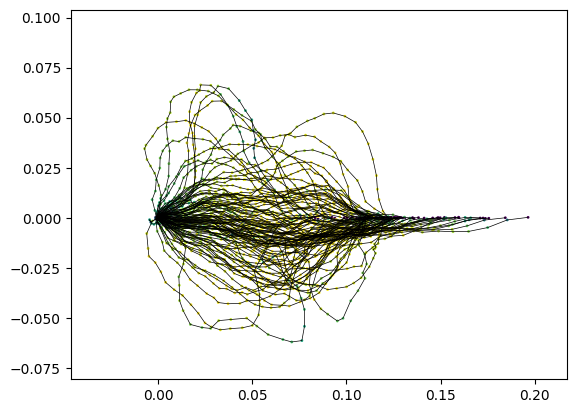

In [102]:
# Visualize generated trajectories
generated_trajectories = model.sample_trajectories(100)
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
for trajectory in generated_trajectories:
    plot_trajectory(ax, trajectory)